# TensorFlow

In [13]:
import tensorflow as tf
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2


Najważniejszą rzeczą do zrozumienia jest to, że ten kod w rzeczywistości nie wykonuje żadnych obliczeń, nawet jeśli wygląda na to (szczególnie na ostatniej linii). Po prostu tworzy graf obliczeniowy. 

W rzeczywistości nawet zmienne nie zostały jeszcze zainicjowane. Aby wykonać ten graf, należy otworzyć sesję TensorFlow i użyć jej do zainicjowania zmiennych i wyliczenia $f$. 

Sesja TensorFlow zajmuje się umieszczaniem operacji na urządzeniach takich jak procesory i GPU oraz ich uruchomieniem i przechowuje wszystkie wartości zmiennych:


In [14]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

42


Ciągłe powtarzanie sesji **sess.run()** jest nieco uciążliwe, ale na szczęście jest lepszy sposób:

In [15]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
    print(result)

42


Zamiast ręcznie uruchamiać inicjalizator dla każdej zmiennej, można użyć skrótu
Funkcja **global_variables_initializer()**. Zauważ, że nie wykonuje on natychmiastowej nitlizacji, lecz tworzy na wykresie węzeł, który inicjalizuje wszystkie zmienne podczas działania:

In [16]:
init = tf.global_variables_initializer() # prepare an init node
with tf.Session() as sess:
    init.run() # actually initialize all the variables
    result = f.eval()
    print(result)

42


Program TensorFlow dzieli się zazwyczaj na dwie części: pierwsza część tworzy graf obliczeniowy (nazywa się to fazą konstrukcyjną), a druga część uruchamia go (jest to faza wykonania).

# Tworzeniw grfów
Każdy utworzony węzeł jest automatycznie dodawany do domyślnego grafu:

In [17]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

W większości przypadków jest to w porządku, ale czasami możesz chcieć zarządzać wieloma niezależnymi grafami. Możesz to zrobić, tworząc nowy graf i tymczasowo ustawiając go jako domyślny wykres wewnątrz bloku:

In [18]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is graph

True

In [19]:
x2.graph is tf.get_default_graph()

False

W Jupyter (lub w powłoce Pythona) często używa się tych samych poleceń więcej niż raz podczas eksperymentowania. W rezultacie może pojawić się domyślny wykres zawierający wiele zduplikowanych węzłów. Jednym z rozwiązań jest ponowne uruchomienie jądra Jupytera (lub powłoki Pythona), ale wygodniejszym rozwiązaniem jest przywrócenie domyślnego wykresu poprzez uruchomienie **tf.reset_default_graph()**.

Podczas inicjalizacji węzła TensorFlow automatycznie określa zestaw węzłów, od których zależy i najpierw inicjalizuje te węzły. Rozważmy na przykład następujący kod:

In [20]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3
with tf.Session() as sess:
    print(y.eval()) 
    print(z.eval()) 

10
15


# Linear Regression with TensorFlow

Weźmy dane housing oraz wykonajmy regresję liniową za pomocą rozwiązania układu równań liniowych.

In [21]:
import numpy as np
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
m, n = housing.data.shape
print(m, n)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
housing_data_scaled=scaler.fit_transform(housing.data)

20640 8


Za pomocą NumPy wyglądało by to tak:

In [22]:
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing_data_scaled]
print(housing_data_plus_bias.shape)

(20640, 9)


In [23]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[ 2.06855817]
 [ 0.8296193 ]
 [ 0.11875165]
 [-0.26552688]
 [ 0.30569623]
 [-0.004503  ]
 [-0.03932627]
 [-0.89988565]
 [-0.870541  ]]


Za pomocą Scikit-Learn można to zrobić tak:

In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_data_scaled, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[ 2.06855817]
 [ 0.8296193 ]
 [ 0.11875165]
 [-0.26552688]
 [ 0.30569623]
 [-0.004503  ]
 [-0.03932627]
 [-0.89988565]
 [-0.870541  ]]


W tensorflow możemy to zrobić tak

In [25]:
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

In [26]:
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
with tf.Session() as sess:
    theta_value = theta.eval()
    print(theta_value)

[[ 2.06856298]
 [ 0.82961965]
 [ 0.11875178]
 [-0.26552707]
 [ 0.30569667]
 [-0.00450281]
 [-0.03932635]
 [-0.8998825 ]
 [-0.87053877]]


# Zad.
Wykonaj regresje na poniższych danych oraz narysuj wykres

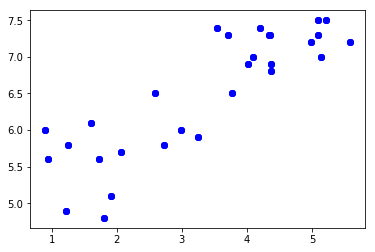

In [52]:
import numpy as np
import tensorflow as tf
data = np.loadtxt("life_satisfaction.csv",
                  dtype=np.float32,
                  delimiter=",",
                  skiprows=1,
                  usecols=[1, 2])
X_train = data[:, 0:1] / 10000 # feature scaling
y_train = data[:, 1:2]

import matplotlib.pyplot as plt

plt.plot(X_train, y_train, "bo")
plt.show()

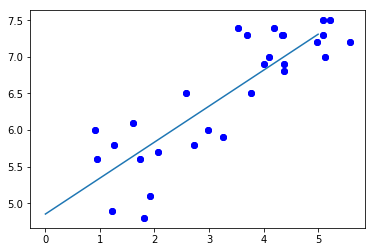

# Implementing Gradient Descent
Możemy zminimalizować funkcję kosztu gradientowo wykorzystując gradient:
```python
gradients = 2/m * tf.matmul(tf.transpose(X), error)
```

In [79]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    print(best_theta)

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371
[[  2.06855226e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845096e-01]
 [  1.64778158e-01]
 [  7.44080753e-04]
 [ -3.91945168e-02]
 [ -8.61356616e-01]
 [ -8.23479712e-01]]


# Zad.
Wykonaj regresje powyższym sposobem na danych life_satisfaction.csv oraz narysuj wykres:

Możemy też użyć gradientu wyliczonego za pomocą automatycznego różniczkowania
```python
gradients = tf.gradients(mse, [theta])[0]
```

In [25]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

gradients = tf.gradients(mse, [theta])[0]

training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371
Best theta:
[[  2.06855249e+00]
 [  7.74078071e-01]
 [  1.31192386e-01]
 [ -1.17845066e-01]
 [  1.64778143e-01]
 [  7.44078017e-04]
 [ -3.91945094e-02]
 [ -8.61356676e-01]
 [ -8.23479772e-01]]


# Zad.
Wykonaj regresje powyższym sposobem na danych life_satisfaction.csv oraz narysuj wykres:

## Ciekwaostka

Jak można znaleźć pochodne czaskowe poniższej funkcji w odniesieniu do a i b?


In [86]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

my_func(0.2, 0.3)

-0.21253923284754914

In [87]:
tf.reset_default_graph()

a = tf.Variable(0.2, name="a")
b = tf.Variable(0.3, name="b")
z = tf.constant(0.0, name="z0")
for i in range(100):
    z = a * tf.cos(z + i) + z * tf.sin(b - i)

grads = tf.gradients(z, [a, b])
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    print(z.eval())
    print(sess.run(grads))

-0.212537
[-1.1388494, 0.19671395]


## Gradient Descent Optimizer

Możemy również użyć wbudowanej funkcji do optymalizacji

```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
```

In [ ]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)


init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Jest wiele różnych metod optymalizacji

In [ ]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")


optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

# Zad.
Wykonaj regresje powyższym sposobem na danych life_satisfaction.csv oraz narysuj wykres:

# Warstwa typu placeholder
Warstwa typu placeholder pozwala na dynamiczne dostarczanie danych

In [ ]:
tf.reset_default_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)
print(B_val_2)

W naszym przypadku mamy:

In [95]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [97]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))


def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    X_batch = housing_data_plus_bias[indices] 
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")
    
print("Best theta:")
print(best_theta)    

Best theta:
[[ 2.07001591]
 [ 0.82045609]
 [ 0.1173173 ]
 [-0.22739051]
 [ 0.31134021]
 [ 0.00353193]
 [-0.01126994]
 [-0.91643935]
 [-0.87950081]]


In [98]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval() 

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [99]:
print(best_theta_restored)

[[ 2.07001591]
 [ 0.82045609]
 [ 0.1173173 ]
 [-0.22739051]
 [ 0.31134021]
 [ 0.00353193]
 [-0.01126994]
 [-0.91643935]
 [-0.87950081]]


# Zad.
Wykonaj regresje powyższym sposobem na danych life_satisfaction.csv oraz narysuj wykres:

# Zbudujmy prostą sieć neuronową

Wykorzystamy dane w kształcie księżyców

In [101]:
import sklearn.datasets
data_X, data_y = sklearn.datasets.make_moons(n_samples=1000, noise=.05)

Najprostszym sposobem nauczenia MLP za pomocą TensorFlow jest wykorzystanie API wysokiego poziomu **TF.Learn**, który jest dość podobny do API Scikit-Learn. 

Klasa DNNClassifier ułatwia nauczanie głębokiej sieci neuronowej z dowolną liczbą ukrytych warstw i warstwą wyjściową softmax. 

Na przykład poniższy kod uczy DNN do klasyfikacji z dwiema ukrytymi warstwami (jedną z 300 neuronami, a drugą ze 100 neuronami) i warstwą wyjściową softmax z 10 neuronami:

In [102]:
import tensorflow as tf
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300, 100], n_classes=10,
    feature_columns=feature_columns)

dnn_clf.fit(x=data_X, y=data_y, batch_size=50, steps=40000)
y_pred = list(dnn_clf.predict(data_X))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_evaluation_master': '', '_num_ps_replicas': 0, '_task_type': None, '_session_config': None, '_is_chief': True, '_task_id': 0, '_tf_random_seed': None, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_environment': 'local', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020DD892A908>, '_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_model_dir': 'C:\\Users\\przem85\\AppData\\Local\\Temp\\tmpoga7q041'}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKC

INFO:tensorflow:global_step/sec: 417.298
INFO:tensorflow:step = 5301, loss = 0.000225699 (0.238 sec)
INFO:tensorflow:global_step/sec: 424.397
INFO:tensorflow:step = 5401, loss = 0.000195054 (0.235 sec)
INFO:tensorflow:global_step/sec: 443.266
INFO:tensorflow:step = 5501, loss = 8.04274e-05 (0.226 sec)
INFO:tensorflow:global_step/sec: 447.238
INFO:tensorflow:step = 5601, loss = 0.000197051 (0.225 sec)
INFO:tensorflow:global_step/sec: 451.279
INFO:tensorflow:step = 5701, loss = 0.000139565 (0.221 sec)
INFO:tensorflow:global_step/sec: 449.258
INFO:tensorflow:step = 5801, loss = 0.00023838 (0.224 sec)
INFO:tensorflow:global_step/sec: 389.584
INFO:tensorflow:step = 5901, loss = 0.000123051 (0.261 sec)
INFO:tensorflow:global_step/sec: 417.3
INFO:tensorflow:step = 6001, loss = 0.000183859 (0.236 sec)
INFO:tensorflow:global_step/sec: 385.073
INFO:tensorflow:step = 6101, loss = 0.000134788 (0.262 sec)
INFO:tensorflow:global_step/sec: 420.819
INFO:tensorflow:step = 6201, loss = 0.000148669 (0.23

INFO:tensorflow:step = 13401, loss = 3.44799e-05 (0.291 sec)
INFO:tensorflow:global_step/sec: 358.755
INFO:tensorflow:step = 13501, loss = 0.000103344 (0.275 sec)
INFO:tensorflow:global_step/sec: 402.142
INFO:tensorflow:step = 13601, loss = 8.50163e-05 (0.250 sec)
INFO:tensorflow:global_step/sec: 397.359
INFO:tensorflow:step = 13701, loss = 3.8125e-05 (0.252 sec)
INFO:tensorflow:global_step/sec: 420.819
INFO:tensorflow:step = 13801, loss = 0.000284931 (0.239 sec)
INFO:tensorflow:global_step/sec: 388.07
INFO:tensorflow:step = 13901, loss = 4.95352e-05 (0.259 sec)
INFO:tensorflow:global_step/sec: 391.115
INFO:tensorflow:step = 14001, loss = 5.00989e-05 (0.254 sec)
INFO:tensorflow:global_step/sec: 368.021
INFO:tensorflow:step = 14101, loss = 4.73346e-05 (0.271 sec)
INFO:tensorflow:global_step/sec: 429.889
INFO:tensorflow:step = 14201, loss = 4.42539e-05 (0.235 sec)
INFO:tensorflow:global_step/sec: 343.911
INFO:tensorflow:step = 14301, loss = 5.5443e-05 (0.291 sec)
INFO:tensorflow:global_s

INFO:tensorflow:global_step/sec: 335.805
INFO:tensorflow:step = 21501, loss = 0.000144276 (0.298 sec)
INFO:tensorflow:global_step/sec: 329.154
INFO:tensorflow:step = 21601, loss = 9.22654e-06 (0.305 sec)
INFO:tensorflow:global_step/sec: 407.08
INFO:tensorflow:step = 21701, loss = 3.64299e-05 (0.245 sec)
INFO:tensorflow:global_step/sec: 419.05
INFO:tensorflow:step = 21801, loss = 2.89953e-05 (0.244 sec)
INFO:tensorflow:global_step/sec: 341.553
INFO:tensorflow:step = 21901, loss = 3.20114e-05 (0.289 sec)
INFO:tensorflow:global_step/sec: 374.94
INFO:tensorflow:step = 22001, loss = 2.19647e-05 (0.264 sec)
INFO:tensorflow:global_step/sec: 435.523
INFO:tensorflow:step = 22101, loss = 9.69435e-05 (0.231 sec)
INFO:tensorflow:global_step/sec: 461.731
INFO:tensorflow:step = 22201, loss = 3.82988e-05 (0.218 sec)
INFO:tensorflow:global_step/sec: 419.051
INFO:tensorflow:step = 22301, loss = 1.58896e-05 (0.239 sec)
INFO:tensorflow:global_step/sec: 477.194
INFO:tensorflow:step = 22401, loss = 5.00574

INFO:tensorflow:global_step/sec: 459.6
INFO:tensorflow:step = 29601, loss = 1.86317e-05 (0.217 sec)
INFO:tensorflow:global_step/sec: 397.347
INFO:tensorflow:step = 29701, loss = 2.4959e-05 (0.256 sec)
INFO:tensorflow:global_step/sec: 397.348
INFO:tensorflow:step = 29801, loss = 2.60203e-05 (0.249 sec)
INFO:tensorflow:global_step/sec: 391.113
INFO:tensorflow:step = 29901, loss = 5.90728e-05 (0.254 sec)
INFO:tensorflow:global_step/sec: 403.781
INFO:tensorflow:step = 30001, loss = 2.14614e-05 (0.247 sec)
INFO:tensorflow:global_step/sec: 412.125
INFO:tensorflow:step = 30101, loss = 6.88266e-05 (0.245 sec)
INFO:tensorflow:global_step/sec: 407.077
INFO:tensorflow:step = 30201, loss = 6.48012e-06 (0.245 sec)
INFO:tensorflow:global_step/sec: 379.209
INFO:tensorflow:step = 30301, loss = 2.40528e-05 (0.264 sec)
INFO:tensorflow:global_step/sec: 380.672
INFO:tensorflow:step = 30401, loss = 7.44834e-05 (0.263 sec)
INFO:tensorflow:global_step/sec: 386.567
INFO:tensorflow:step = 30501, loss = 5.7814e

INFO:tensorflow:global_step/sec: 459.602
INFO:tensorflow:step = 37701, loss = 1.03636e-05 (0.217 sec)
INFO:tensorflow:global_step/sec: 479.489
INFO:tensorflow:step = 37801, loss = 0.000107745 (0.211 sec)
INFO:tensorflow:global_step/sec: 443.265
INFO:tensorflow:step = 37901, loss = 8.69446e-05 (0.224 sec)
INFO:tensorflow:global_step/sec: 501.176
INFO:tensorflow:step = 38001, loss = 1.36866e-05 (0.200 sec)
INFO:tensorflow:global_step/sec: 380.665
INFO:tensorflow:step = 38101, loss = 1.53964e-05 (0.265 sec)
INFO:tensorflow:global_step/sec: 463.878
INFO:tensorflow:step = 38201, loss = 2.09805e-05 (0.219 sec)
INFO:tensorflow:global_step/sec: 402.152
INFO:tensorflow:step = 38301, loss = 2.22999e-05 (0.247 sec)
INFO:tensorflow:global_step/sec: 455.409
INFO:tensorflow:step = 38401, loss = 1.46e-05 (0.219 sec)
INFO:tensorflow:global_step/sec: 491.303
INFO:tensorflow:step = 38501, loss = 0.000146781 (0.204 sec)
INFO:tensorflow:global_step/sec: 479.489
INFO:tensorflow:step = 38601, loss = 3.28799

# Zad
Narysuj wynik powyższego programu

INFO:tensorflow:Restoring parameters from C:\Users\przem85\AppData\Local\Temp\tmpoga7q041\model.ckpt-40000


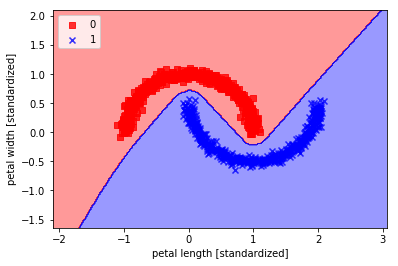

# Możemy też sami zbudować sieć 

In [107]:
tf.reset_default_graph()

n_inputs = 2
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

Wykorzystamy sieć typu fully_connected z funkcją aktywacji relu.


In [108]:
n_neurons=2
with tf.name_scope("linear_model"):
    n_inputs = int(X.get_shape()[1])
    stddev = 2 / np.sqrt(n_inputs)

    init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)

    W = tf.Variable(init, name="weights")
    b = tf.Variable(tf.zeros([n_neurons]), name="biases")
    z = tf.matmul(X, W) + b
    tf.nn.relu(z)

In [109]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([n_neurons]), name="biases")
        z = tf.matmul(X, W) + b
        if activation=="relu":
            return tf.nn.relu(z)
        else:
            return z

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
    hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
    logits = neuron_layer(hidden2, n_outputs, "outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")   
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)    
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    
    
    

In [110]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 40
batch_size = 50

def fetch_batch(epoch, batch_index, batch_size, X,  y):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(X.shape[0], size=batch_size)  # not shown
    X_batch = X[indices] # not shown
    y_batch = y[indices] # not shown
    return X_batch, y_batch

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size, data_X, data_y)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        #acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train)#, "Val accuracy:", acc_val)
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.94
1 Train accuracy: 0.96
2 Train accuracy: 0.9
3 Train accuracy: 0.92
4 Train accuracy: 0.98
5 Train accuracy: 0.96
6 Train accuracy: 0.96
7 Train accuracy: 0.9
8 Train accuracy: 0.9
9 Train accuracy: 1.0
10 Train accuracy: 0.96
11 Train accuracy: 0.98
12 Train accuracy: 0.94
13 Train accuracy: 1.0
14 Train accuracy: 0.98
15 Train accuracy: 0.98
16 Train accuracy: 1.0
17 Train accuracy: 0.98
18 Train accuracy: 1.0
19 Train accuracy: 1.0
20 Train accuracy: 1.0
21 Train accuracy: 1.0
22 Train accuracy: 1.0
23 Train accuracy: 1.0
24 Train accuracy: 1.0
25 Train accuracy: 1.0
26 Train accuracy: 1.0
27 Train accuracy: 1.0
28 Train accuracy: 1.0
29 Train accuracy: 1.0
30 Train accuracy: 1.0
31 Train accuracy: 1.0
32 Train accuracy: 1.0
33 Train accuracy: 1.0
34 Train accuracy: 1.0
35 Train accuracy: 1.0
36 Train accuracy: 1.0
37 Train accuracy: 1.0
38 Train accuracy: 1.0
39 Train accuracy: 1.0


In [111]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = data_X
    Z = logits.eval(feed_dict={X: X_new_scaled})
    print(Z)
    y_pred = np.argmax(Z, axis=1)
    print(Z.shape)
    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
[[-4.50067568  3.48027682]
 [ 5.42456865 -6.61987209]
 [-6.28870821  4.14164305]
 ..., 
 [ 2.17544627 -5.43836355]
 [ 3.57405996 -3.74473214]
 [-1.88609052  2.811836  ]]
(1000, 2)


# Zad
Narysuj wynik powyższego programu

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


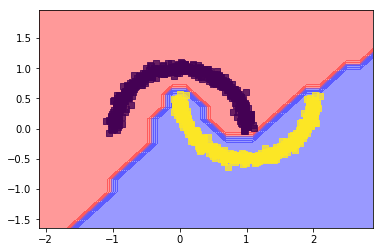

Zamiast samemu implementwać wartwę możmy użyć funkcji fully_connected

```python
from tensorflow.contrib.layers import fully_connected
with tf.name_scope("dnn"):
    hidden1 = fully_connected(X, n_hidden1, scope="hidden1")
    hidden2 = fully_connected(hidden1, n_hidden2, scope="hidden2")
    logits = fully_connected(hidden2, n_outputs, scope="outputs",
    activation_fn=None)
```    

# Zad
Zmodyfikuj powyższy kod tak by wykorzystywał funkcję fully_connected

# Zad
Wykonaj lasyfikację za pomoca sieci nuronowej zzawierającej conajmniej 3 warstwy ukryte na danych iris.